# Kernel PCA Experiments for Spaceship Titanic
Use Kernel PCA with different kernels to reduce dimensionality and a logistic regression head to classify Transported.

**Setup**
- Activate the venv: `source .venv/bin/activate`
- Ensure deps: `pip install pandas scikit-learn matplotlib seaborn` (already installed in this repo).
- Adjust `SAMPLE_SIZE` below if you want to use all rows.

In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
DATA_DIR = Path('Cleaned Spaceship Titanic Dataset')
TRAIN_PATH = DATA_DIR / 'train_clean.csv'
SAMPLE_SIZE = 4000  # set to None to use all rows

df = pd.read_csv(TRAIN_PATH)
y = df['Transported'].astype(int)
X = df.drop(columns=['PassengerId', 'Transported'])

if SAMPLE_SIZE is not None and len(df) > SAMPLE_SIZE:
    X, _, y, _ = train_test_split(
        X, y, train_size=SAMPLE_SIZE, stratify=y, random_state=42
    )

print(f'Shape: X={X.shape}, y={y.shape}, positive_rate={y.mean():.3f}')

Shape: X=(4000, 30), y=(4000,), positive_rate=0.503


In [4]:
n_components = [5, 10]
param_grid = [
    {'kpca__kernel': ['linear'], 'kpca__n_components': n_components},
    {'kpca__kernel': ['cosine'], 'kpca__n_components': n_components},
    {'kpca__kernel': ['rbf'], 'kpca__n_components': n_components, 'kpca__gamma': [0.1]},
    {'kpca__kernel': ['poly'], 'kpca__n_components': n_components, 'kpca__gamma': [0.01], 'kpca__degree': [2, 3], 'kpca__coef0': [0.0]},
    {'kpca__kernel': ['sigmoid'], 'kpca__n_components': n_components, 'kpca__gamma': [0.1], 'kpca__coef0': [0.0, 1.0]},
]
param_grid

[{'kpca__kernel': ['linear'], 'kpca__n_components': [5, 10]},
 {'kpca__kernel': ['cosine'], 'kpca__n_components': [5, 10]},
 {'kpca__kernel': ['rbf'],
  'kpca__n_components': [5, 10],
  'kpca__gamma': [0.1]},
 {'kpca__kernel': ['poly'],
  'kpca__n_components': [5, 10],
  'kpca__gamma': [0.01],
  'kpca__degree': [2, 3],
  'kpca__coef0': [0.0]},
 {'kpca__kernel': ['sigmoid'],
  'kpca__n_components': [5, 10],
  'kpca__gamma': [0.1],
  'kpca__coef0': [0.0, 1.0]}]

In [5]:
pipe = Pipeline(
    steps=[
        ('kpca', KernelPCA(fit_inverse_transform=False, remove_zero_eig=True, random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, n_jobs=1, solver='lbfgs')),
    ]
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'},
    refit='accuracy',
    cv=cv,
    n_jobs=1,
    verbose=1,
    return_train_score=False,
)
grid

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('kpca',
                                        KernelPCA(random_state=42,
                                                  remove_zero_eig=True)),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=1))]),
             n_jobs=1,
             param_grid=[{'kpca__kernel': ['linear'],
                          'kpca__n_components': [5, 10]},
                         {'kpca__kernel': ['cosine'],
                          'kpca__n_components': [5, 10]},
                         {'kpca__..., 'kpca__kernel': ['rbf'],
                          'kpca__n_components': [5, 10]},
                         {'kpca__coef0': [0.0], 'kpca__degree': [2, 3],
                          'kpca__gamma': [0.01], 'kpca__kernel': ['poly'],
                          'kpca__n_components': [5, 10]},
                         {'kpca__coef0': [0.0, 1.0], 'kpca__gamma': [0.1],
                          'kpca__kernel': ['sigmoid'],
                          'kpca__n_components': [5, 10]}],
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}, verbose=1)

In [6]:
grid.fit(X, y)

best_params = grid.best_params_
best_acc = grid.best_score_
best_auc = grid.cv_results_['mean_test_roc_auc'][grid.best_index_]
print('Best params:', best_params)
print(f'Best CV accuracy: {best_acc:.4f}')
print(f'Best CV ROC-AUC: {best_auc:.4f}')

results_df = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False)
cols = ['mean_test_accuracy', 'mean_test_roc_auc', 'param_kpca__kernel', 'param_kpca__n_components', 'param_kpca__gamma', 'param_kpca__degree', 'param_kpca__coef0']
results_df[cols].head(10)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params: {'kpca__coef0': 0.0, 'kpca__gamma': 0.1, 'kpca__kernel': 'sigmoid', 'kpca__n_components': 10}
Best CV accuracy: 0.7855
Best CV ROC-AUC: 0.8751


,mean_test_accuracy,mean_test_roc_auc,param_kpca__kernel,param_kpca__n_components,param_kpca__gamma,param_kpca__degree,param_kpca__coef0
11,0.785495,0.875083,sigmoid,10,0.1,NaN,0.0
1,0.783745,0.870688,linear,10,NaN,NaN,NaN
13,0.783494,0.871981,sigmoid,10,0.1,NaN,1.0
3,0.749991,0.839562,cosine,10,NaN,NaN,NaN
5,0.732244,0.815562,rbf,10,0.1,NaN,NaN
12,0.689244,0.740568,sigmoid,5,0.1,NaN,1.0
0,0.679231,0.738198,linear,5,NaN,NaN,NaN
10,0.674746,0.725255,sigmoid,5,0.1,NaN,0.0
2,0.644247,0.683927,cosine,5,NaN,NaN,NaN
4,0.635997,0.668637,rbf,5,0.1,NaN,NaN


### Visualize CV performance

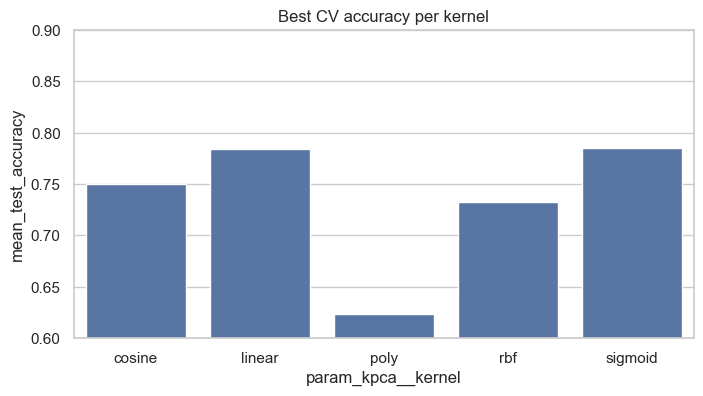

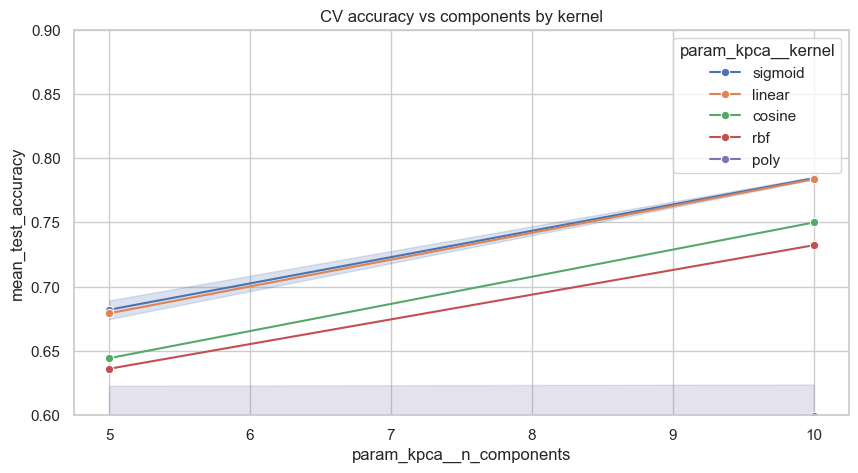

In [7]:
# Best accuracy by kernel
best_by_kernel = (
    results_df.groupby('param_kpca__kernel')['mean_test_accuracy']
    .max()
    .reset_index()
)
plt.figure(figsize=(8,4))
sns.barplot(data=best_by_kernel, x='param_kpca__kernel', y='mean_test_accuracy')
plt.title('Best CV accuracy per kernel')
plt.ylim(0.6, 0.9)
plt.show()

# Accuracy vs components for each kernel
plt.figure(figsize=(10,5))
sns.lineplot(
    data=results_df,
    x='param_kpca__n_components',
    y='mean_test_accuracy',
    hue='param_kpca__kernel',
    marker='o',
)
plt.title('CV accuracy vs components by kernel')
plt.ylim(0.6, 0.9)
plt.show()

### Visualize best kernel PCA embedding (first two components)

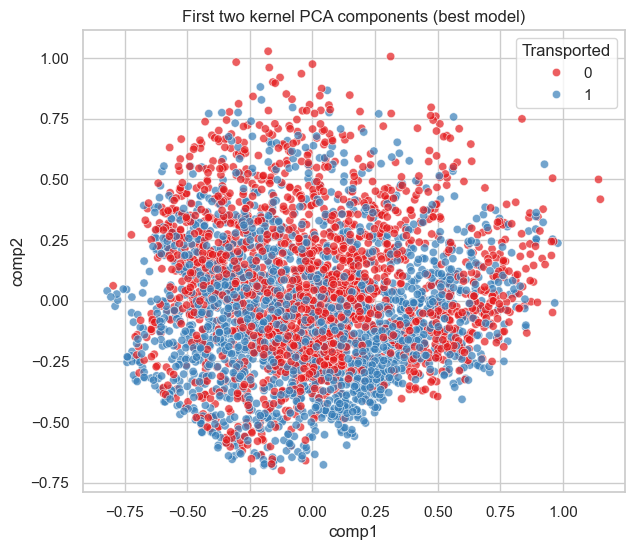

In [8]:
best_model = grid.best_estimator_
Z = best_model.named_steps['kpca'].transform(X)

if Z.shape[1] >= 2:
    emb_df = pd.DataFrame(Z[:, :2], columns=['comp1', 'comp2'])
    emb_df['Transported'] = y.reset_index(drop=True)
    plt.figure(figsize=(7,6))
    sns.scatterplot(data=emb_df, x='comp1', y='comp2', hue='Transported', palette='Set1', alpha=0.7)
    plt.title('First two kernel PCA components (best model)')
    plt.show()
else:
    print('Embedding has <2 components; adjust n_components to visualize.')

### Training-set classification report (sanity check)

In [9]:
y_pred = best_model.predict(X)
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8190    0.7362    0.7754      1986
           1     0.7634    0.8396    0.7997      2014

    accuracy                         0.7883      4000
   macro avg     0.7912    0.7879    0.7876      4000
weighted avg     0.7910    0.7883    0.7876      4000

